In [1]:
import math
import numpy as np
import pandas as pd
import time as time
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
from keras import layers
from sklearn.metrics import confusion_matrix, precision_score,recall_score,accuracy_score, f1_score,classification_report

In [2]:
df = pd.read_csv('/content/diabetes_binary_5050split_health_indicators_BRFSS2015.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

In [4]:
df.isnull().sum()

Diabetes_binary         0
HighBP                  0
HighChol                0
CholCheck               0
BMI                     0
Smoker                  0
Stroke                  0
HeartDiseaseorAttack    0
PhysActivity            0
Fruits                  0
Veggies                 0
HvyAlcoholConsump       0
AnyHealthcare           0
NoDocbcCost             0
GenHlth                 0
MentHlth                0
PhysHlth                0
DiffWalk                0
Sex                     0
Age                     0
Education               0
Income                  0
dtype: int64

In [5]:
def train_cost(training_duration_hours):
  #According to GCE Pricing
  gpu_cost = 0.35
  storage_cost = 0.020
  compute_cost = 0.03398
  storage = 78 #GB provided by Colab
  training_duration_hours = (training_duration_hours/60)/60

  total_cost = (storage_cost*storage) + (gpu_cost*training_duration_hours) + (compute_cost*training_duration_hours)
  return total_cost

#EDA

####Feature Engeineering

In [6]:
print("rows in dataset: ",df.shape[0])
print("duplicate rows: ",df.duplicated().sum())

rows in dataset:  70692
duplicate rows:  1635


In [7]:
print("rows in dataset: ",df.shape[0])
print("duplicate rows: ",df.duplicated().sum())
df = df.drop_duplicates()
print("rows after dropping duplicates in  dataset: ",df.shape[0])

rows in dataset:  70692
duplicate rows:  1635
rows after dropping duplicates in  dataset:  69057



```
In the following cells we have implemented Jaccard Similarity Score.
It helps us find the similairty score by dividing the intersection of 2 categorical columns by the union of those 2 columns
```



In [8]:
#Dropping continuous and multi-class variables to compute jaccard similarity score
newdf = df.drop(df[['GenHlth','MentHlth','PhysHlth','Age','Education','Income']], axis=1)

In [9]:
def jaccard_similarity(column_a, column_b):
    intersection = sum((column_a == 1) & (column_b == 1))
    union = sum((column_a == 1) | (column_b == 1))
    return intersection / union if union != 0 else 0

In [10]:
cols = newdf.columns.tolist()
threshold = 0.7 #a threshold of 0.7 means any columns with a similairty score of 0.7 or more will be printed by the loop
for c1 in cols:
    for c2 in cols:
        if c1 != c2:
            js = jaccard_similarity(newdf[c1], newdf[c2])
            if js > threshold:
                print(c1, c2) #we eliminated one of these columns based on the similarity score
                print(js)

CholCheck Veggies
0.7684244241912471
CholCheck AnyHealthcare
0.9377464174001601
Veggies CholCheck
0.7684244241912471
Veggies AnyHealthcare
0.7596100278551532
AnyHealthcare CholCheck
0.9377464174001601
AnyHealthcare Veggies
0.7596100278551532




```
AnyHealthcare and CholCheck had a high similarity score with multiple variables hence they have been eliminated
```



In [11]:
newdf = df.drop(newdf[['AnyHealthcare','CholCheck']], axis=1)

In [12]:
newdf.head()

,Diabetes_binary,HighBP,HighChol,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,HvyAlcoholConsump,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,26.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,26.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,29.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0


In [13]:
X = newdf.values[:, 1:]
y = newdf.values[:, 0]

In [14]:
train_X, X_temp, train_y, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val,test_X, y_val, test_y = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

#### Visualizations

<Axes: xlabel='Diabetes_binary', ylabel='count'>

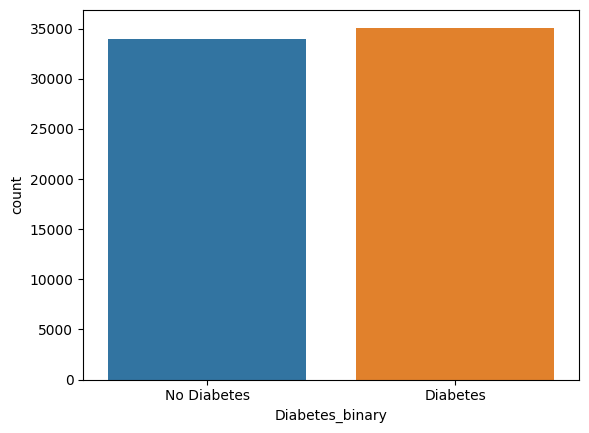

In [15]:
sns.countplot(x=newdf['Diabetes_binary'].replace({0: 'No Diabetes', 1: 'Diabetes'}), data=newdf)

In [16]:
def plotting(data2, x_column):
    _df_plot = data2.groupby([x_column, df['Diabetes_binary'].replace({0: 'No Diabetes', 1: 'Diabetes'})]).size().reset_index().pivot(columns='Diabetes_binary', index=x_column, values=0)

    return _df_plot

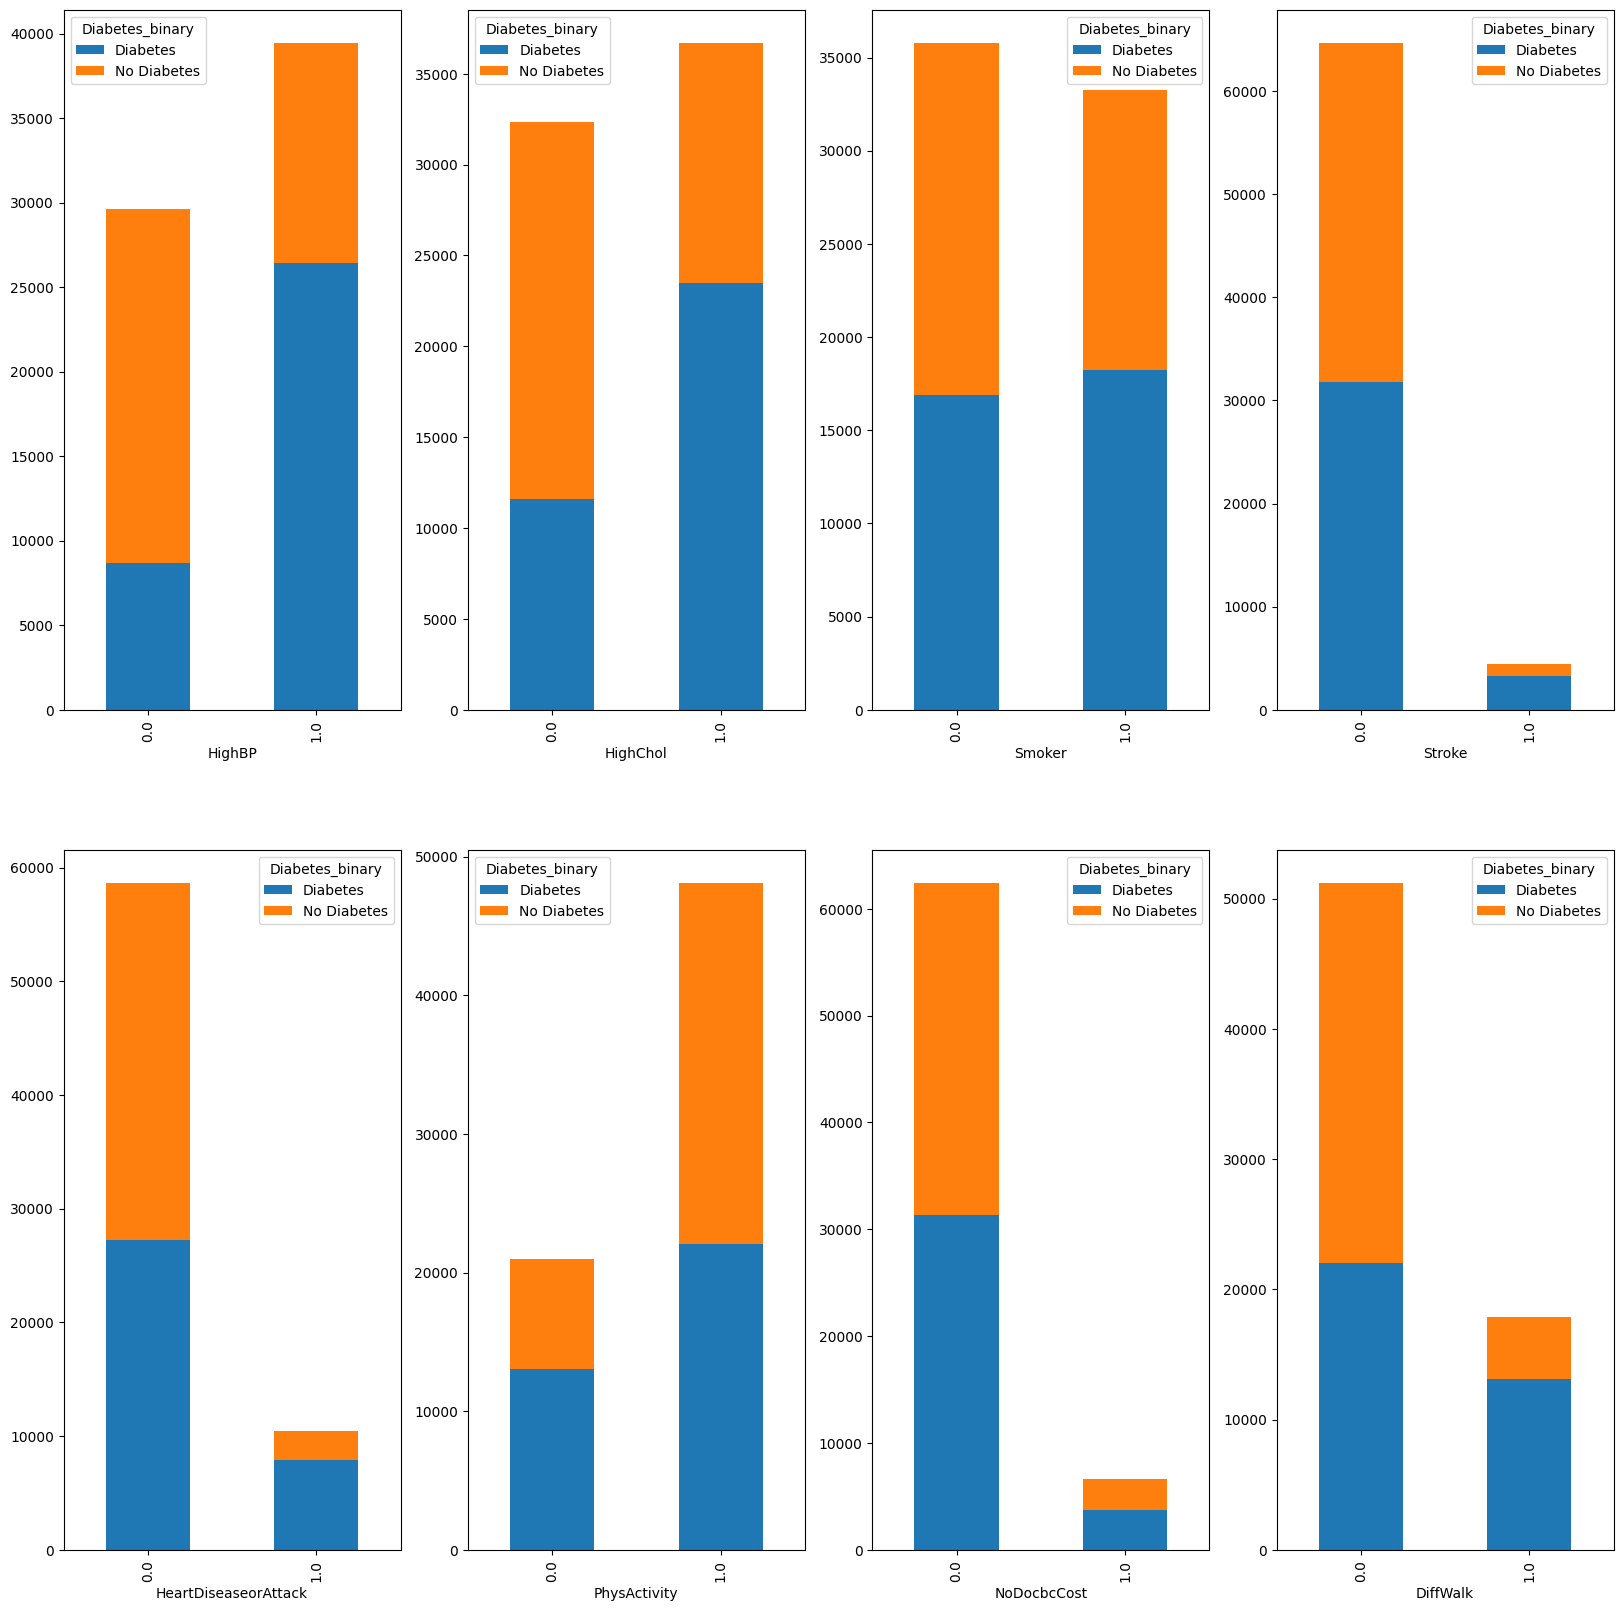

In [17]:
cols = ['HighBP', 'HighChol','Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity','NoDocbcCost', 'DiffWalk']

fig, ax = plt.subplots(2, 4, figsize=(20,20))
axe = ax.ravel()

c = len(cols)

for i in range(c):
    plotting(newdf, cols[i]).plot(kind='bar',stacked=True, ax=axe[i])
    axe[i].set_xlabel(cols[i])

fig.show()

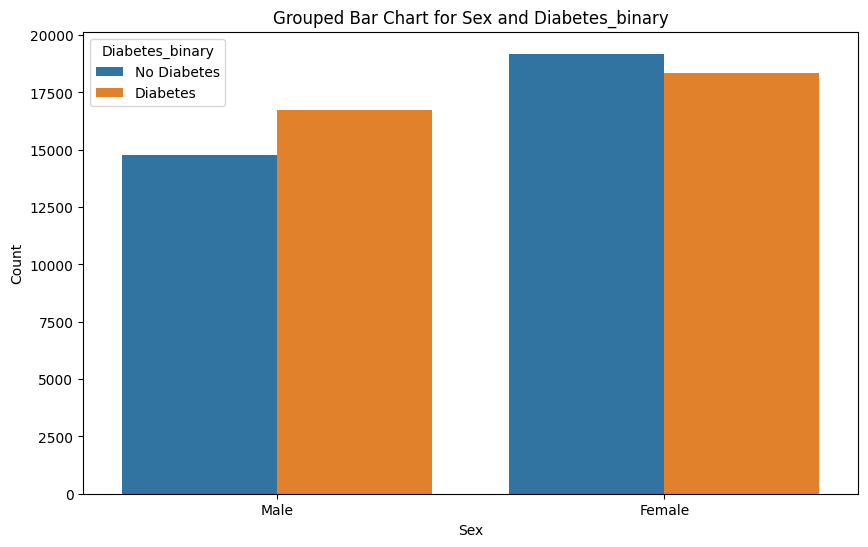

In [18]:
plt.figure(figsize=(10, 6))
sns.countplot(x=newdf['Sex'].replace({0: 'Female', 1: 'Male'}), hue=newdf['Diabetes_binary'].replace({0: 'No Diabetes', 1: 'Diabetes'}), data=newdf)
plt.title('Grouped Bar Chart for Sex and Diabetes_binary')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(title='Diabetes_binary')
plt.show()

# Models



```
We wil be using a Logistic regression model as our baseline to compare the accuracy metrics, time-taken to train and cost of training
```



#### Logistic regression with Elastic Nets



```
Elastic net is a combination of L1 and L2 regularization to overcome the limitations of both regularization techniques.
q here is the penalty term. When it is set 0, Elastic net is the equivalent of L2 regularization. When it is set to 1,
Elastic Net is the equivalent of L1 regularization
```



In [19]:
@dataclass
class LogisticRegression:

    datapath: pd.DataFrame
    learning_rate: float
    max_iterations: int
    alpha: float  = 1
    epsilon: float = 0.0005
    q: float = 1.0    # New parameter for Elastic Net with default value set to L1 regularization
    global train_X, train_y,test_X,test_y

    def sigmoid(self, X):
        return 1 / (1 + np.exp(-X.dot(self.theta)))

    def cost_function(self, X, y):
        sig = self.sigmoid(X)
        epsilon = 1e-15
        sig = np.clip(sig, epsilon, 1 - epsilon)
        regularizer = self.alpha * np.sum(np.power(np.abs(self.theta),self.q))  # Elastic Net regularization term
        cost = (1 / X.shape[0]) * (y * np.log(sig) + (1 - y) * np.log(1 - sig)) + regularizer
        return -cost.sum()

    def cost_derivative(self, X, y):
        sig = self.sigmoid(X)
        grad = (sig - y).dot(X)
        regularizer = self.alpha * np.sign(self.theta)
        grad += regularizer
        return grad

    def gradient_descent(self, X, y):
        self.errors = []
        prev_error = float('inf')
        for i in tqdm(range(self.max_iterations), colour='red'):
            self.theta -= self.learning_rate * self.cost_derivative(X, y)
            error = self.cost_function(X, y)
            self.errors.append(error)
            if abs(prev_error - error) < self.epsilon:
                print('Model stopped')
                break
            prev_error = error

    def fit(self):
        self.theta = np.ones(train_X.shape[1])
        self.gradient_descent(train_X, train_y)

    def predict(self, X):
        probability = self.sigmoid(X)
        return (probability >= 0.5).astype(int)

    def predict_proba(self, X):
        probability = self.sigmoid(X)
        return probability

In [20]:
start_time = time.time()
lr = LogisticRegression(datapath = newdf, epsilon = 0.00005, learning_rate=0.1e-4, max_iterations=10000,q=0.8)
lr.fit()
end_time = time.time()

100%|██████████| 10000/10000 [00:38<00:00, 257.50it/s]


In [21]:
elapsed_time = end_time - start_time
print(f"Execution time: {elapsed_time} seconds")

Execution time: 38.84209179878235 seconds


In [22]:
lr.theta.round()

array([ 65.,  38.,   5., -12.,   7.,  21., -19.,  -6., -12., -23., -11.,
        15.,  -0.,   1.,  16.,   7.,   2., -20.,  -6.])

In [23]:
predictions = lr.predict(X_val)
cm = confusion_matrix(y_val, predictions)

In [24]:
print(confusion_matrix(y_val,predictions))

[[1404 3595]
 [ 148 5212]]


In [25]:
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

         0.0       0.51      0.16      0.24      5121
         1.0       0.51      0.86      0.64      5238

    accuracy                           0.51     10359
   macro avg       0.51      0.51      0.44     10359
weighted avg       0.51      0.51      0.44     10359



#### Neural Networks

In [47]:
model = keras.Sequential([
    layers.InputLayer(input_shape=(train_X.shape[1],)),
    layers.Dense(512, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(64, activation='relu', kernel_regularizer=keras.regularizers.l2(0.01)),
    layers.Dense(1, activation='sigmoid')
])

In [48]:
start_time2 = time.time()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(train_X, train_y, epochs=10, validation_data=(X_val, y_val))
end_time2 = time.time()

Epoch 1/10
1511/1511 [==============================] - 17s 10ms/step - loss: 1.0276 - accuracy: 0.6660 - val_loss: 0.5952 - val_accuracy: 0.7249
Epoch 2/10
1511/1511 [==============================] - 10s 7ms/step - loss: 0.6033 - accuracy: 0.7091 - val_loss: 0.5713 - val_accuracy: 0.7339
Epoch 3/10
1511/1511 [==============================] - 7s 5ms/step - loss: 0.5889 - accuracy: 0.7135 - val_loss: 0.5549 - val_accuracy: 0.7418
Epoch 4/10
1511/1511 [==============================] - 8s 5ms/step - loss: 0.5852 - accuracy: 0.7170 - val_loss: 0.5593 - val_accuracy: 0.7378
Epoch 5/10
1511/1511 [==============================] - 8s 5ms/step - loss: 0.5818 - accuracy: 0.7164 - val_loss: 0.5684 - val_accuracy: 0.7331
Epoch 6/10
1511/1511 [==============================] - 7s 5ms/step - loss: 0.5807 - accuracy: 0.7206 - val_loss: 0.5501 - val_accuracy: 0.7424
Epoch 7/10
1511/1511 [==============================] - 8s 5ms/step - loss: 0.5781 - accuracy: 0.7200 - val_loss: 0.5467 - val_accura

In [49]:
elapsed_time2 = end_time2 - start_time2
print(f"Execution time: {elapsed_time2} seconds")

Execution time: 143.46880888938904 seconds


In [50]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 512)               10240     
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 64)                8256      
                                                                 
 dense_15 (Dense)            (None, 1)                 65        
                                                                 
Total params: 84225 (329.00 KB)
Trainable params: 8422

# Bias Variance Tradeoff

#### For logistic regression

In [51]:
def bias_variance_decomp(y_true,y_pred):
  variance = np.sum((y_pred-np.mean(y_pred))**2)/y_pred.shape[0]
  bias = np.power(np.sum((y_pred - y_true)**2),0.5)/y_pred.shape[0]
  return bias, variance

In [52]:
iters = [5,10,20,50,100,200,500,1000,2000]
var,bias = [],[]
for i in iters:
  lr = LogisticRegression(datapath = newdf, epsilon = 0.00005, learning_rate=0.1e-4, max_iterations=i,q=0.8)
  lr.fit()
  y_pred = lr.predict(test_X)
  b,v = bias_variance_decomp(test_y,y_pred)
  var.append(v)
  bias.append(b)

100%|██████████| 2000/2000 [00:07<00:00, 253.25it/s]


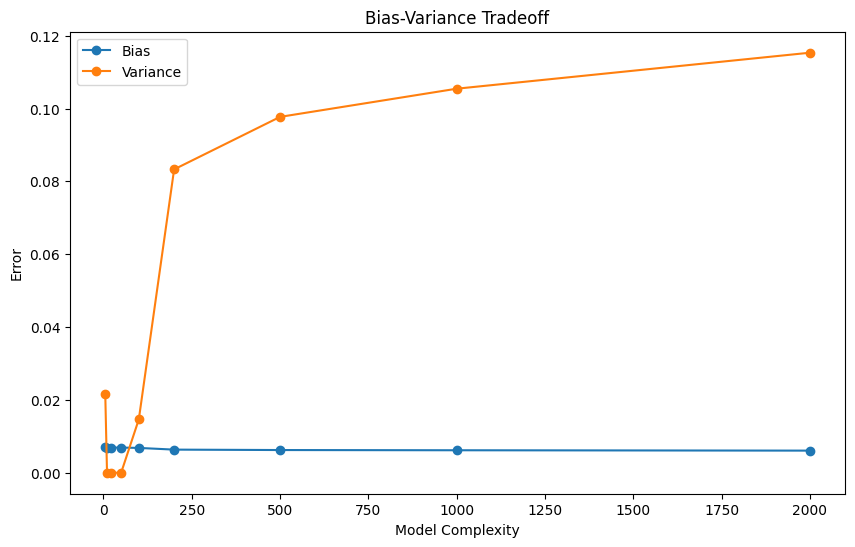

In [53]:
plt.figure(figsize=(10, 6))
plt.plot(iters, bias, label='Bias', marker='o')
plt.plot(iters, var, label='Variance', marker='o')
plt.xlabel('Model Complexity')
plt.ylabel('Error')
plt.title('Bias-Variance Tradeoff')
plt.legend()
plt.show()

#### For Neural Networks

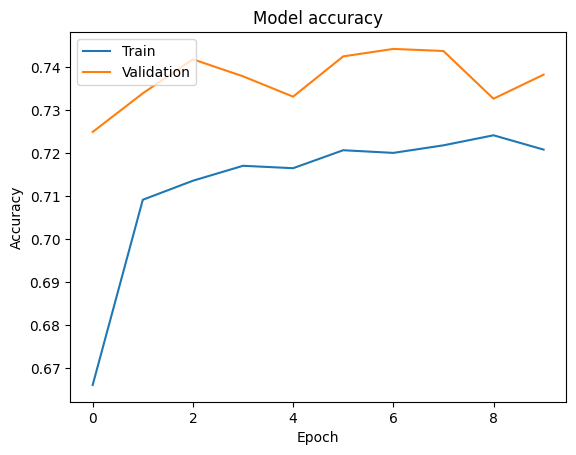

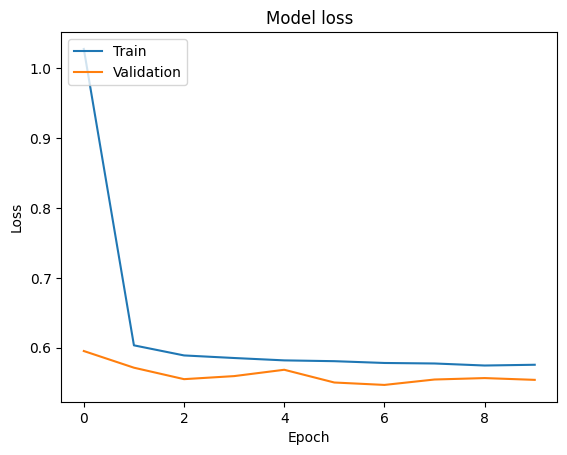

In [54]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Model Evaluation

#### For Logistic with Elastic Nets

In [55]:
predictions = lr.predict(test_X)
cm = confusion_matrix(test_y, predictions)

In [56]:
print(confusion_matrix(test_y,predictions))

[[1274 3847]
 [ 104 5134]]


In [57]:
print(classification_report(test_y,predictions))

              precision    recall  f1-score   support

         0.0       0.92      0.25      0.39      5121
         1.0       0.57      0.98      0.72      5238

    accuracy                           0.62     10359
   macro avg       0.75      0.61      0.56     10359
weighted avg       0.75      0.62      0.56     10359



In [58]:
logi_cost = train_cost(elapsed_time)
print(f"Cost of training: {logi_cost} $")

Cost of training: 1.564142940669138 $


#### For Neural Networks

In [59]:
y_pred_prob = model.predict(test_X)
pred = (y_pred_prob >= 0.5).astype(int)

324/324 [==============================] - 1s 2ms/step


In [60]:
print(confusion_matrix(test_y,pred))

[[3265 1856]
 [ 848 4390]]


In [61]:
print(classification_report(test_y,pred))

              precision    recall  f1-score   support

         0.0       0.79      0.64      0.71      5121
         1.0       0.70      0.84      0.76      5238

    accuracy                           0.74     10359
   macro avg       0.75      0.74      0.74     10359
weighted avg       0.75      0.74      0.74     10359



In [62]:
nn_cost = train_cost(elapsed_time2)
print(f"Cost of training: {nn_cost} $")

Cost of training: 1.57530254256593 $


In [63]:
model_names = ['Logistic', 'NN']
metrics = ['Precision', 'Recall', 'Accuracy', 'Time', 'Cost']
model_a_metrics = [precision_score(test_y,predictions),recall_score(test_y,predictions),accuracy_score(test_y,predictions),elapsed_time,logi_cost]
model_b_metrics = [precision_score(test_y,pred),recall_score(test_y,pred),accuracy_score(test_y,pred),elapsed_time2,nn_cost]
data = {'Model': model_names,}
for i, metric in enumerate(metrics):
  data[metric] = [model_a_metrics[i], model_b_metrics[i]]
results = pd.DataFrame(data)

In [64]:
results.head()

,Model,Precision,Recall,Accuracy,Time,Cost
0,Logistic,0.571651,0.980145,0.618593,38.842092,1.564143
1,NN,0.702850,0.838106,0.738971,143.468809,1.575303
